# DATA 620 Final Project: Systemized AirBnB Listings
#### Team Members: Stefano Biguzzi, Ian Costello, Dennis Pong  


### Deliverables Schedule
|Deliverable |Date |Points|
|:---|---|:---:|
|Final Project Proposal|Sunday July 11|25|
|Final Project| Sunday July 18| 150|
|Final Project Presentation| By Video|50|

### Policy on Collaboration 
You may work in a team of up to three people. Each project team member is responsible for understanding and being able to explain all of the submitted project code. Remember that you can take work that you find elsewhere as a base to build on, but you need to acknowledge the source, so that I base your grade on what you contributed, not on what you started with!

### [Final Project Proposal ](https://github.com/sbiguzzi/data620/blob/main/Assignments/FinalProject/FinalProj_Proposal.pdf)
Your proposal should describe at a high level what you’re seeking to accomplish, and your motivation for performing this analysis. A guiding question or hypothesis to test is one good way to start. If you are going to work in a small group (encouraged!), you should also list your partners’ names. 
You should briefly describe your data sources; plan for doing the work, and up front concerns. If you are working in a group, please describe the roles and responsibilities of each group member. 
We’ll treat this proposal as a planning document, not a blue print containing “firm, fixed requirements.” 

### Final Project 
Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

### Final Project Presentation - YouTube Link
We’ll schedule a short presentation for each team, either in our last scheduled meet-up or in additional office hours to be scheduled during the last week of classes.


## Introduction
We were inspired by a recent article in [Towards Data Science](https://towardsdatascience.com/identifying-potential-scam-listings-on-airbnb-e9aed41611e5) (which was in turn inspired by a [Wired](https://www.wired.co.uk/article/airbnb-scam-london) article) which demonstrated that network analysis could be used to detect fake reviewers of Airbnb stays. We took a different approach exploring a 2015 law mentioned in the article, “…which allows Londoners to let their home on a short-term basis without the need for planning permission, for up to 90 nights a year.” This law, while providing a great economic benefit for residents opens the door for potential abuse through “systematizing” a single listing by signing up for multiple accounts. 

Our project plans to demonstrate that network analysis through connection between guests and hosts can detect hosts who use multiple accounts for the same unit to skirt this law and rent out their space for more than 90 days. Other geographies could reapply this method to understand if systemization is an issue.

The primary data source for this project us [Inside Airbnb](http://insideairbnb.com/get-the-data.html), a repository of publicly available data that is cleaned and aggregated for open use. The site contains many geographies to use. We have selected London because of this distinctive law that seemingly eases up on restrictions when other cities are cracking down. Additionally, London has many more listings than any other location initially reviewed, which improves our chances to find what we are looking for.

## Import Libraries
First we import the libraries we are going to use for the following assignment. `networkx` will be our main library for the network analysis piece.

In [1]:
# general libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import re
import seaborn as sns
from IPython.display import IFrame

# network analysis
import networkx as nx
from networkx.algorithms import bipartite

# text analysis
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# formatting commands
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

## Important Function

In [2]:
# function to get graph components of size one
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [item for sublist in [list(c) for c in nx.connected_components(B) if len(c) == 1] for item in sublist]
    num_components = len(components)
    return components, num_components

# function to get large graph components
def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

# function to clean string
def clean_string(text):
    '''Take any text and return a cleaned version of the text
        without punctuation, lower cased, and removes stopwords'''
    text = ''.join([w for w in text if w not in string.punctuation])
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords])
    
    return text

# function to get the ngrams of a word or phrase
def ngrams(string, n=2):
    '''Takes any string removes characters, and creates
        ngrams of length n. Returns string and ngrams of
        string'''
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# function to get the top n cosine similarity scores
def cos_sim_top(A, B, ntop, lower_bound=0):
    '''Takes any matrix A and B and returns the top n
        matching values with the higest cosine similarity
        score'''
    
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
    
    idx_dtype = np.int32
    
    nnz_max = M*ntop
    
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)
    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)
    return csr_matrix((data,indices,indptr),shape=(M,N))

# function to return the names that were run through the cos_sim_top function
def get_matches_df(sparse_matrix, name_vector, top=None):
    '''Takes any sparse matrix constructed from a name vector
        and returns the names and scores of values in the sparse
        matrix with a defned % cut off'''
    
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similairity})

## Loading Data

First step is to load the listing and review data. We check the shape of both data frames and see that the listing_df has 74 columns and 74,840 rows, while the reviews_df has 6 columns and 1,129,280 rows.

_We needed to run it from our local drive as the files were too big to store on github and we were not aware of other file storage website that would interact seamlessly with python._

In [3]:
os.chdir(r'C:/Users/biguz/Desktop/CUNY Data Science/Summer2021/DATA 620/Assignments/Final Project')

In [4]:
# loading listing data
# listing_url = 
listing_df = pd.read_csv('listings.csv',dtype=object)
listing_df.rename(columns={'id':'listing_id'},inplace=True)
listing_df.shape

(74840, 74)

In [5]:
# loading reviews data
reviews_df = pd.read_csv('reviews.csv',dtype=object)
reviews_df.shape

(1129280, 6)

## Data Cleaning
We need to clean the data up a bit before we start building to nodes and edges of our network. First we cant to drop rows from the review_df where there are null comments. This removes 503 rows from our data. We also want to remove anything with 'This is an automated posting' in the comment section. This reduces the data by another 19,338 rows. We want to merge the reviews_df columns `['listing_id','reviewr_id','reviewer_name','id','date','comments']` with the listing_df columns `['listing_id','host_id','host_name']` on `listing_id` giving us a dataframe with 1,109,439 rows and 8 columns. We then drop NAs and remove duplicate reviews, shrinking our data by 27,452 rows. We also remove carriage returns from the comments column. Checking the info of the dataframe we see that we have 1,081,987 rows, 8 columns, and no null values. The next step is to construct our network graph.

In [6]:
# drop null comments from review data
reviews_df.dropna(inplace=True)
reviews_df.shape

(1128777, 6)

In [7]:
# drop reviews containing 'This is an automated posting'
automated = reviews_df[reviews_df.comments.str.contains('This is an automated posting')].index
reviews_df.drop(index=automated, inplace=True)
reviews_df.shape

(1109439, 6)

In [8]:
# set up dataframes to merge
df_review = reviews_df[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df_listing = listing_df[['listing_id', 'host_id', 'host_name']].copy()

# merge the dataframes
df_merged = pd.merge(df_review, df_listing, how='left', on='listing_id')
df_merged.shape

(1109439, 8)

In [9]:
# clean the merged dataframe
df_merged.dropna(inplace=True)
df_merged.drop_duplicates(subset=['id'], inplace=True)
df_merged.comments = df_merged.comments.map(lambda x: x.replace('\r', ''))
df_merged.reviewer_id = df_merged.reviewer_id.astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081987 entries, 0 to 1109438
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1081987 non-null  object
 1   reviewer_id    1081987 non-null  int32 
 2   reviewer_name  1081987 non-null  object
 3   id             1081987 non-null  object
 4   date           1081987 non-null  object
 5   comments       1081987 non-null  object
 6   host_id        1081987 non-null  object
 7   host_name      1081987 non-null  object
dtypes: int32(1), object(7)
memory usage: 70.2+ MB


## Creating Network Graph


### Data Wrangling
First we wanted to make the calculations for how we wanted to restrict our data following these three criteria:
1.	Hosts with multi-listings that are greater than or equal to five
2.	Reviewers who reviewed multiple hosts (greater than two)
3.	Hosts and reviewers where the reviewers left multiple reviews for a host

To do this we first created the `host_listing_counts` dataframe which gives us the counts of listings by host id. Next we run the `host_review_counts` dataframe that calculates the number of reviews per host. Then we create `reviewer_review_counts` to calculate the number of reviews by reviewers. Finally, we create `reviewer_host_counts` to calculate the number of hosts each reviewer has reviewed.

In [10]:
# calculate number of listings by host
host_listing_counts = df_merged.groupby('host_id')[['listing_id']].nunique().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_counts'}, inplace=True)

# calculate the number of reviews per hosts
host_review_counts = df_merged.groupby('host_id')[['id']].nunique().reset_index()
host_review_counts.rename(columns={'id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer
reviewer_review_counts = df_merged.groupby('reviewer_id')[['id']].nunique().reset_index()
reviewer_review_counts.rename(columns={'id': 'reviewer_review_count'}, inplace=True)

# calculate number of hosts reviewed by reviewers
reviewer_host_counts = df_merged.groupby(['reviewer_id'])[['host_id']].nunique().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_counts'}, inplace=True)

We then create a `df_merged_final` dataframe were we take the original `df_merged` and merge onto it the new dataframes we created. This gives us a final dataframe with 12 columns and 1,081,987 rows.

In [11]:
df_merged_final = pd.merge(df_merged, host_review_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_review_counts, how='left', on='reviewer_id')
df_merged_final = pd.merge(df_merged_final, host_listing_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_host_counts, how='left', on='reviewer_id')
df_merged_final.shape

(1081987, 12)

### Visualizing Counts
We can visualize all the counts for each dataframe we created in the steps above. For all the dataframes we can see that the majority of the counts are closer to 0 than to the maximum. This helps us determine how many edges to eliminate in our graph data. Since we are looking for edges between hosts and reviewers that fall within specific criteria, we know that hosts will drop out. This help us narrow the search for hosts that are potentially systemizing their listings.

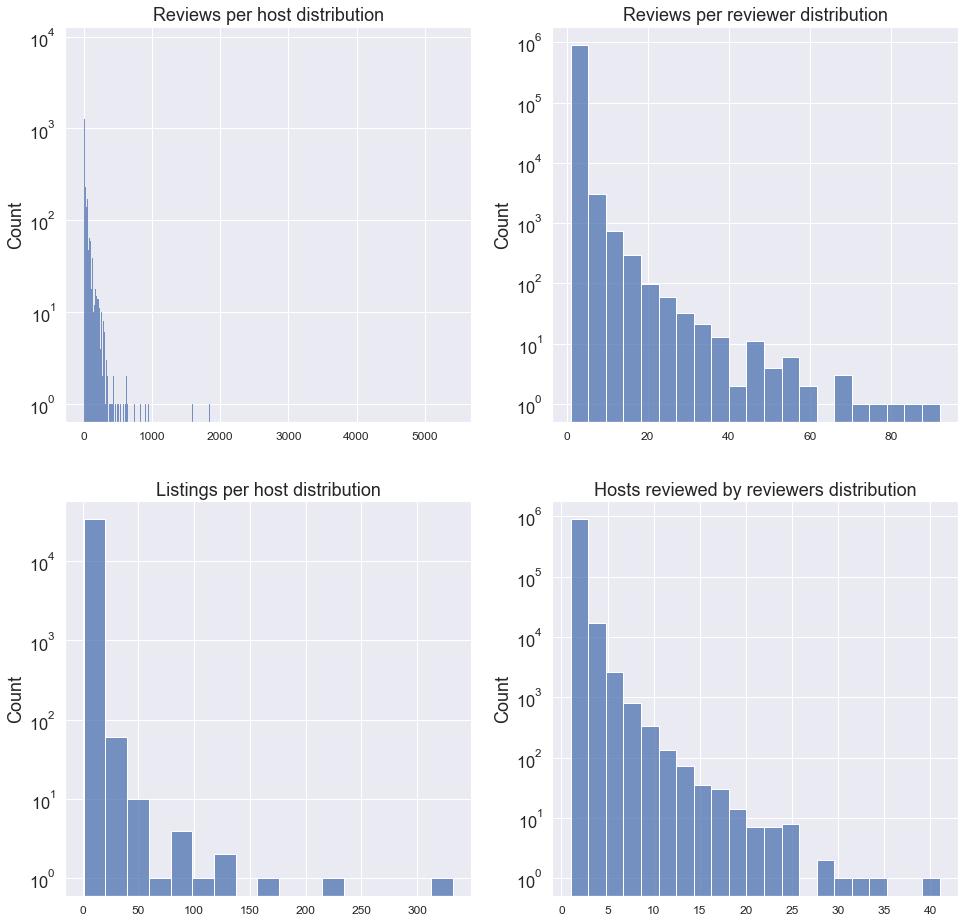

In [12]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(16, 16))
sns.histplot(host_review_counts.host_review_count, ax=ax[0,0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[0,1])
sns.histplot(host_listing_counts.host_listing_counts, ax=ax[1,0])
sns.histplot(reviewer_host_counts.reviewer_host_counts, ax=ax[1,1])
ax[0,0].set_title('Reviews per host distribution')
ax[0,1].set_title('Reviews per reviewer distribution')
ax[1,0].set_title('Listings per host distribution')
ax[1,1].set_title('Hosts reviewed by reviewers distribution')

for a in ax.flatten():
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=12, labelrotation=0)
    a.set_yscale('log')

plt.show()

### Subsetting
For the purposes of this project we decided to subset the `df_merged_final` dataframe by figuring out where there are duplicated _host_ids_ and _reviewer_ids_. This is how we find if the edges for reviewers that reviewed the same host more than once. We then subset the dataframe further by dropping any duplicate rows on the following columns: `['host_id', 'reviewer_id', 'listing_id', 'date']`. This leaves us with only one row for each review instance, allowing us to create edges from this. We then finish subsetting by only getting the edges for hosts with 5 or more listings and reviewers who have reviewed more than 2 hosts. This leaves us with a dataset of 12 columns and 3,435 rows, which includes 1,018 reviewers and 348 hosts.

In [13]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False)
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.shape

(3439, 12)

In [14]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  1018
Number of hosts:  348


In [15]:
h_dict = pd.Series(subset.host_name.values,index=subset.host_id).to_dict()
r_dict = pd.Series(subset.reviewer_name.values,index=subset.reviewer_id).to_dict()
labels_dict = {**h_dict,**r_dict}

### Initial 2-Mode Network
We instantiate the graph with the subset data using `nx.from_pandas_dataframe` and setting the to and from equal to `reviewer_id` and `host_id` respectively. This creates a graph with 1,366 nodes and 1,173 edges.

In [16]:
G = nx.from_pandas_dataframe(subset,'reviewer_id','host_id')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1366
Number of edges: 1173
Average degree:   1.7174


We visuzlize the graph below with red being the <font color='red'>__reviewers__</font> and blue being the <font color='blue'>__hosts__</font>. It's still a semi large network and doesn't really help us with what we are trying to accomplish. For this we will have to create a projected graph onto the hosts.

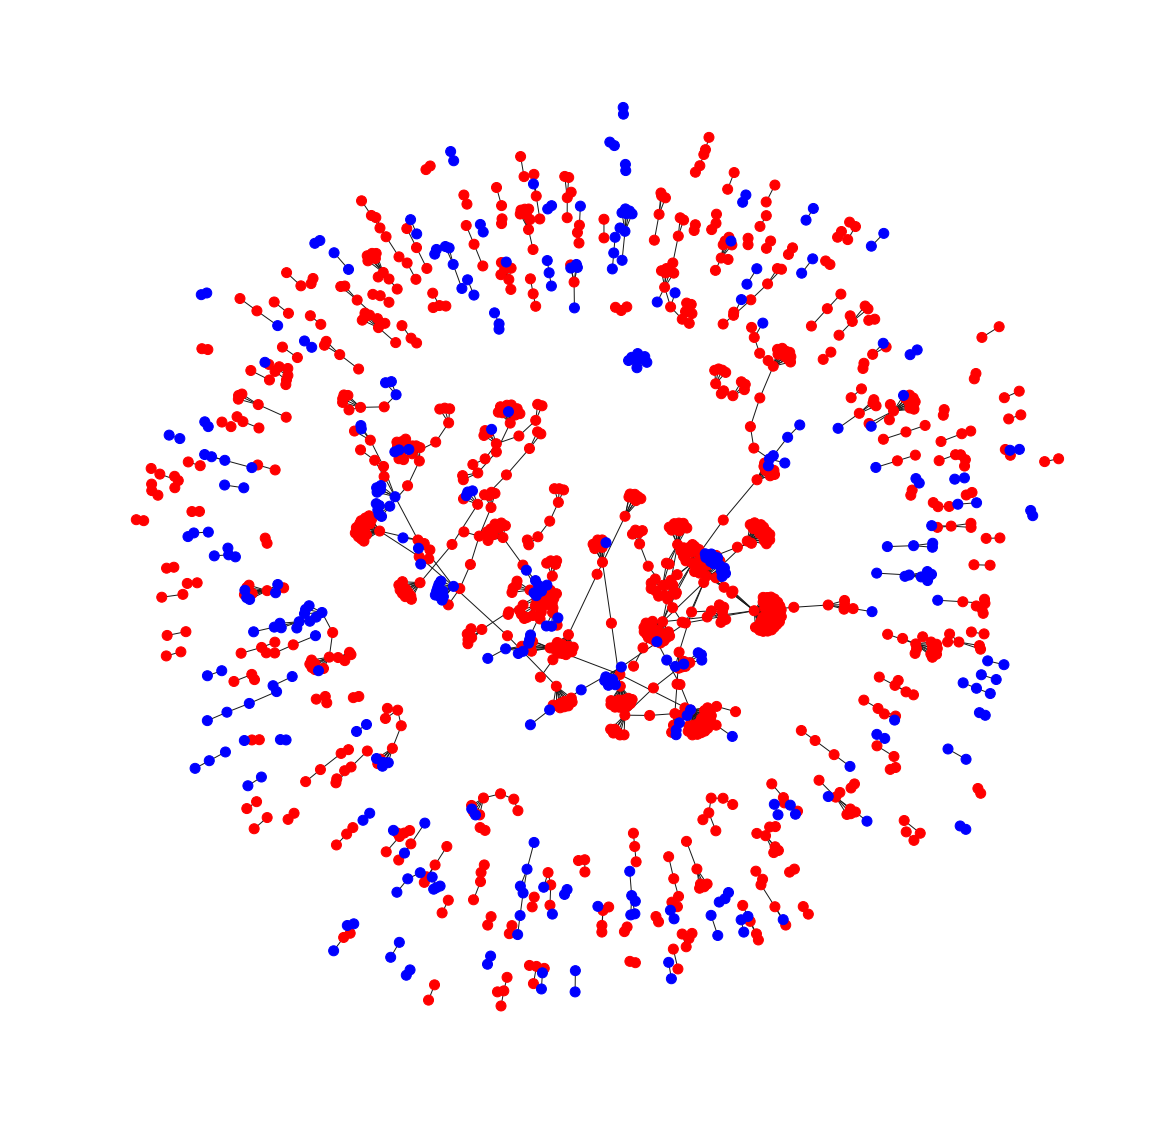

In [17]:
# nodes
reviewer_nodes = subset.reviewer_id.unique().tolist()
host_nodes = subset.host_id.unique().tolist()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,iterations=35)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

### Projected Host Graph
We create the projected graph of the hosts and how they would connect based on their connection to reviewers. This leaves us with a graph of 348 nodes and 260 edges, but when we look at the image of the graph it's still hard to understand what is happening. We have to remove some of the noise that exists in the graph.

In [18]:
# look at projected graph (on hosts)
B = bipartite.projected_graph(G, subset.host_id.unique().tolist())
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 348
Number of edges: 260
Average degree:   1.4943


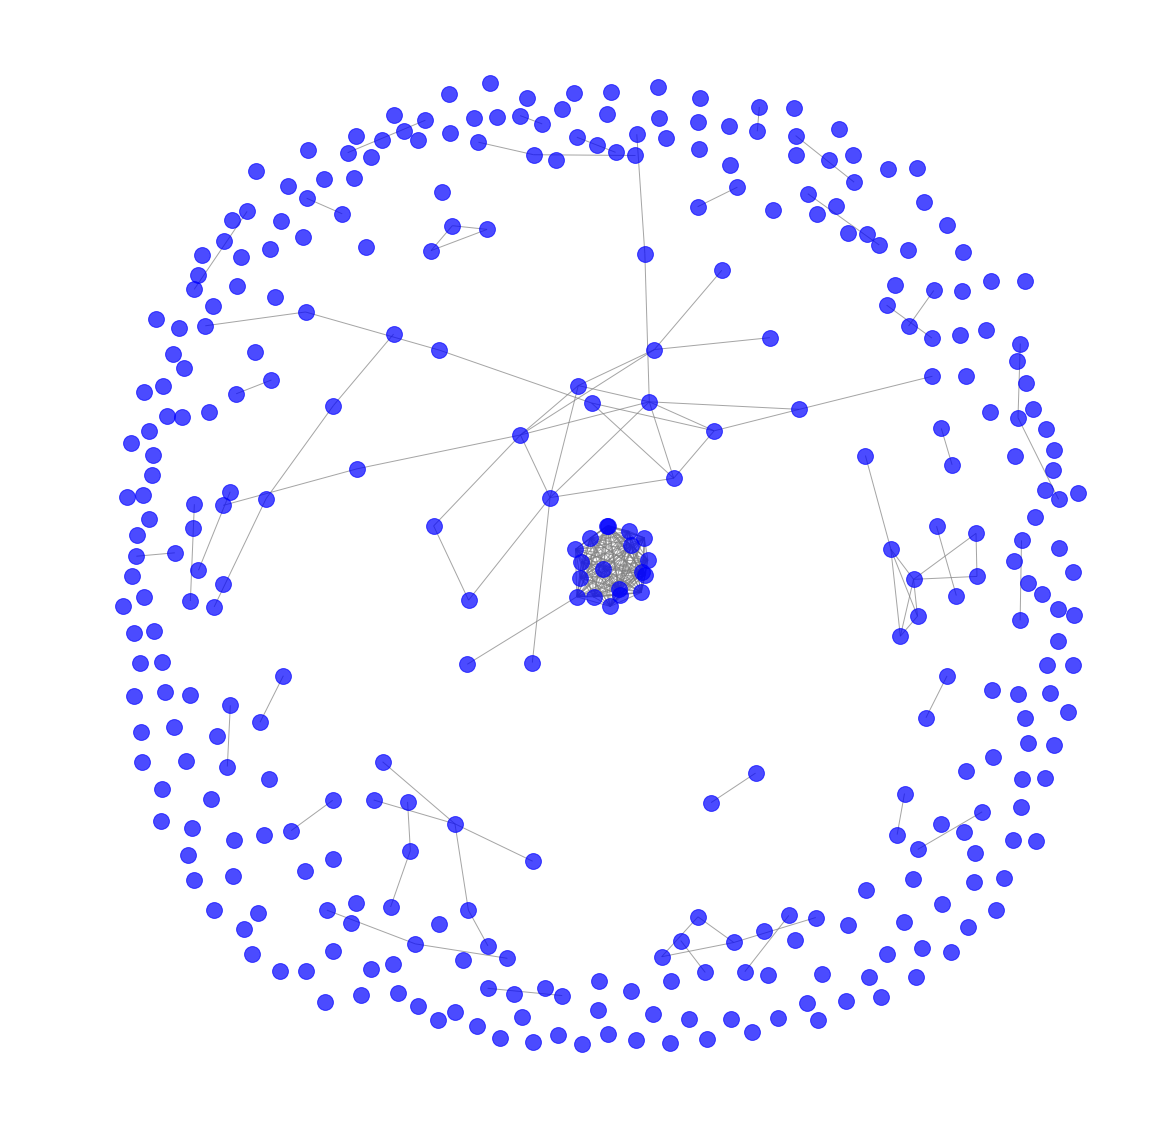

In [19]:
pos = nx.spring_layout(B,iterations=15)
labels = {node: labels_dict[node] for node in B.nodes()}

# plot host graph
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(B, pos, node_size=250,node_color='blue',alpha=0.7)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.7,edge_color='grey')
plt.axis("off")
plt.show()

What stands out the greatest is the number of single nodes, i.e. nodes with no edges. These nodes should be eliminated from our graph as they are clearly not hosts that are systemizing their listing. Even if they were this method of network analysis would not be optimal to discovering their wrongdoings. Using our function `component_size_one` we can get the count and the list of nodes that are of size one.

In [20]:
# identify the components with no links
components_one, n_one = component_size_one(B)

print("Number of components of size one:", n_one)

Number of components of size one: 214


We can use the list of nodes, `components_one`, and the nx function `remove_nodes_from`, to remove all the single nodes from the projected graph B. This gives us a final project graph of 134 nodes and 260 edges. This means we have 39 components to analyze instead of (214+39), or 253, making it easier to see potential patterns.

In [21]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 134
Number of edges: 260
Average degree:   3.8806


In [22]:
GCC, components, n = giant_component_size(B)
print("Number of components greater than one:", n)

Number of components greater than one: 39


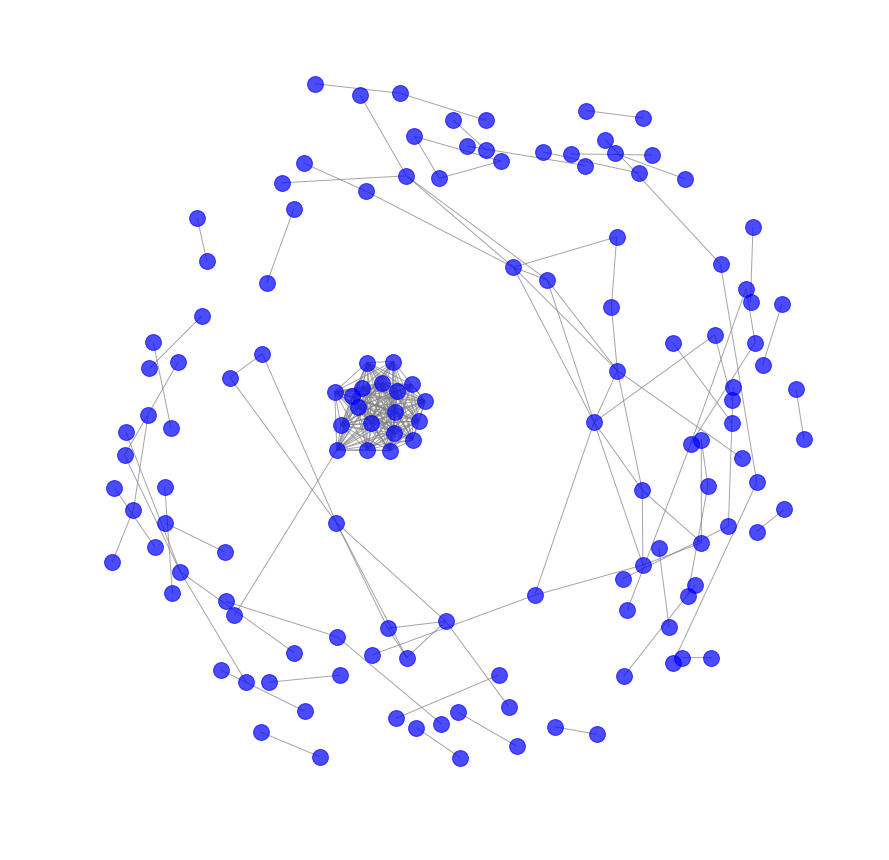

In [23]:
# plot graph B
pos = nx.spring_layout(B,iterations=16)
labels = {node: labels_dict[node] for node in B.nodes()}

plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(B, pos, node_size=250,node_color='blue',alpha=0.7)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.7,edge_color='grey')
plt.axis("off")
plt.show()

For the next steps we focused on a two components. One component of 7 nodes and one component of 20 nodes.

## Potential Success

We first isolate the component of size 7 and create a graph. When we plot the graph with labels to see if we can see any similarly named hosts. We found two sets, _Billie And Max_ being very similar to _Max and Billie_ and _Sonder(London)_ being the same name as _Sonder_. For this section we decided to focus on _Max and Billie_ as Sonder seems to be an AirBnB listings management company (which would not meet the same criteria as individuals when it comes to systemized listings).

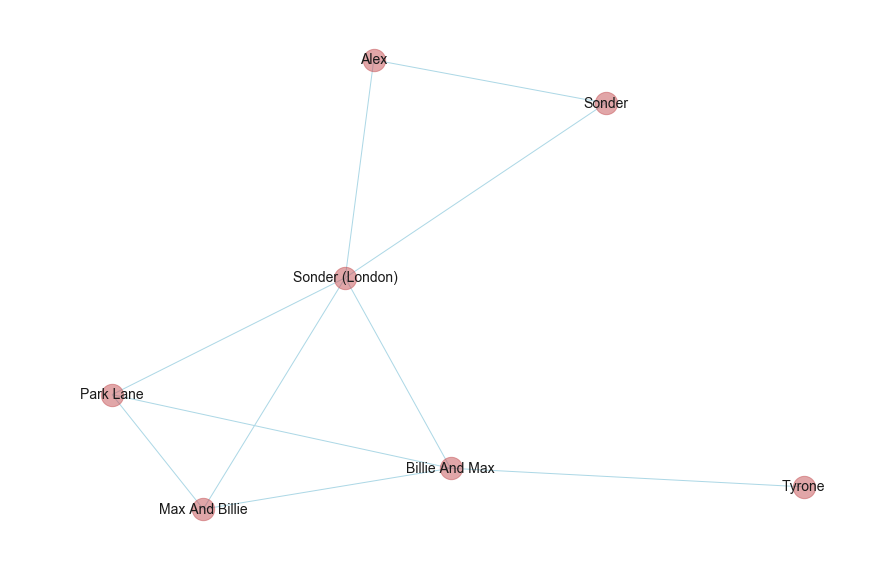

In [24]:
# plot one of the components
B_sub_1 = B.subgraph(components[19][1])

pos = nx.spring_layout(B_sub_1)
labels = {node: labels_dict[node] for node in B_sub_1.nodes()}

# create plot
plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(B_sub_1, pos, node_size=500,color='red',alpha=0.5)
nx.draw_networkx_edges(B_sub_1, pos, width=1, edge_color='lightblue',alpha=1)
nx.draw_networkx_labels(B_sub_1, pos, labels=labels, font_size=14, font_family="sans-serif")
plt.axis("off")
plt.show()

We then take the node list from the above graph and isolate the component in the original subset graph, `G`.

In [25]:
network_1 = subset[subset.host_id.isin(components[19][1])]

# plot network with reviewers added back in
G_net_1 = nx.Graph()
G_net_1.add_nodes_from(network_1.reviewer_id.unique(), bipartite=0)
G_net_1.add_nodes_from(network_1.host_id.unique(), bipartite=1)
G_net_1.add_edges_from(network_1[['reviewer_id', 'host_id']].values)

# node attributes
node_data = {}
for node in G_net_1:
    if node in network_1.reviewer_id.unique():
        node_data.update({node:'reviewer'})
    if node in network_1.host_id.unique():
        node_data.update({node:'host'})

nx.set_node_attributes(G_net_1,'labels',node_data)

In [26]:
Gnet1_cent_df = pd.DataFrame(nx.degree_centrality(G_net_1).items(),columns=['graph_id','degree'])
Gnet1_cent_df['eigenvector'] = nx.eigenvector_centrality_numpy(G_net_1).values()
Gnet1_cent_df['betweenness'] = nx.betweenness_centrality(G_net_1).values()
Gnet1_cent_df['closeness'] = nx.closeness_centrality(G_net_1).values()
Gnet1_cent_df.merge(pd.DataFrame(node_data.items(),columns=['graph_id','label']),on='graph_id',how='left').sort_values('betweenness',ascending=False).head(n=10)

,graph_id,degree,eigenvector,betweenness,closeness,label
53,226472167,0.218182,0.192638,0.582828,0.374150,host
49,82436841,0.345455,0.674053,0.531650,0.354839,host
17,8688619,0.072727,0.222861,0.528620,0.401460,reviewer
54,224866971,0.127273,0.073719,0.374747,0.329341,host
50,69479387,0.200000,0.022002,0.333333,0.258216,host
26,94147884,0.036364,0.048291,0.325926,0.307263,reviewer
20,21245807,0.054545,0.019819,0.169697,0.263158,reviewer
16,250111091,0.036364,0.194994,0.133333,0.333333,reviewer
51,1504322,0.072727,0.005257,0.107071,0.214008,host
52,12243051,0.054545,0.009113,0.038047,0.212355,host


Calculating the centrality measures, we see that the hosts are at the top of the betweeness scores. If we take the top 10 betweeness scores and identify the hosts and reviewers we'll be able to see the triads that represent the hosts that are potentially systemizing their listing. The graph below shows how Max and Billie connects to Billie and Max via reviews from Sheilla and Michelle.

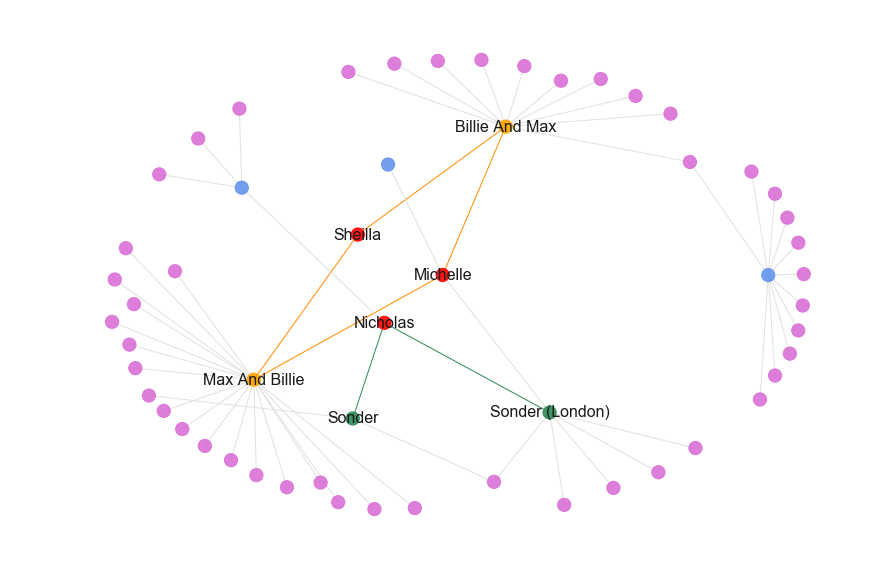

In [27]:
# node color
colors_net_1 = []
for node in G_net_1.nodes():
    if node in [8688619,250111091,21245807]:
        colors_net_1.append('red')
    elif node in ['226472167','82436841']:
        colors_net_1.append('orange')
    elif node in ['224866971','12243051']:
        colors_net_1.append('seagreen')
    elif node in network_1.host_id.unique():
        colors_net_1.append('cornflowerblue')
    else:
        colors_net_1.append('orchid')

# edge color
edge_color_net_1 = []
for edge in G_net_1.edges():
    if any([val in edge for val in ['226472167','82436841']]) & \
    any([val in edge for val in [8688619,250111091]]):
        edge_color_net_1.append('darkorange')
    elif any([val in edge for val in [21245807]]) & \
    any([val in edge for val in ['224866971','12243051']]):
        edge_color_net_1.append('seagreen')
    else:
        edge_color_net_1.append('#e1e1dd')
        
# nodes
reviewer_nodes = network_1.reviewer_id.unique()
host_nodes = network_1.host_id.unique()
labels = {node: labels_dict[node] for node in ['224866971','12243051','226472167','82436841',
                                               8688619,250111091,21245807]}

# create plot
plt.figure(figsize=(15,10))
pos = nx.spring_layout(G_net_1,iterations=60)
nx.draw_networkx_nodes(G_net_1, pos, node_size=175, node_color=colors_net_1, alpha=0.9)
nx.draw_networkx_edges(G_net_1, pos, width=1, edge_color=edge_color_net_1, alpha=1)
nx.draw_networkx_labels(G_net_1, pos, labels=labels, font_size=16, font_family="sans-serif")
plt.axis("off")
plt.show()

This, however, is not enough to definitively say that fraud is being committed, there needs to be additional information. One thing we can do is run the hosts' names through a text similarity function. We take the host names from the listing_df and clean them up a bit so that there are no spaces, stopwords, or punctuation. We see an example of this below.

In [28]:
names_net1_df = listing_df[['host_name','host_id']][listing_df['host_id'].isin(components[19][1])].drop_duplicates().reset_index(drop=True)
for w in names_net1_df['host_name']:
    w1 = w.lower()
    for ele in w1:
        if ele in string.punctuation+' ':
            w1 = w1.replace(ele,'')
    names_net1_df['host_name'].replace(w,w1,inplace=True)
names_net_1 = names_net1_df['host_name']
names_net_1.head()

0            alex
1    maxandbillie
2          tyrone
3          sonder
4        parklane
Name: host_name, dtype: object

We initialize the vectorizer we want to use to compare the names and tell it to vectorize the bigrams of our names by running them through the function `ngrams`. We fit the names to compare and run the bigram sparse matrix into our `cos_sum_top` function, which will return to us the top 10 names with a cosine similarity score above 0.6. This gets return in sparse matrix format and needs to be converted back into the name.

In [29]:
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix_net_1 = vectorizer.fit_transform(names_net_1)
matches_net_1 = cos_sim_top(tf_idf_matrix_net_1, tf_idf_matrix_net_1.transpose(), 10, 0.6)

To achieve this we run the sparse matrix through our other function `get_matches_df` and we filter out any names that matched with a similarity score above 0.99, excluding the scores in the sparse matrix where the name matched itself. We add the url of the profile picture the the matched names from listing_df.

In [30]:
matches_net1_df = get_matches_df(matches_net_1, names_net_1,top=None)
matches_net1_df = matches_net1_df[matches_net1_df['similarity'] < 0.99]
matches_net1_df = matches_net1_df.rename(columns={'left_side':'host_name'}).merge(names_net1_df,on='host_name',how='left').merge(listing_df[['host_id','host_url']].drop_duplicates(),on='host_id',how='left')
matches_net1_df = matches_net1_df.rename(columns = {'host_name':'host_left','right_side':'host_names',
                                                    'host_url':'host_url_left','right_side':'host_name'}).drop('host_id',axis=1).merge(names_net1_df,on='host_name',how='left').merge(listing_df[['host_id','host_url']].drop_duplicates(),on='host_id',how='left')
matches_net1_df = matches_net1_df.rename(columns={'host_url':'host_url_right','host_name':'host_right'}).drop('host_id',axis=1)
matches_net1_df.drop_duplicates('similarity').sort_values('similarity',ascending=False).reset_index(drop=True)

,host_left,host_right,similarity,host_url_left,host_url_right
0,sonder,sonderlondon,0.757253,https://www.airbnb.com/users/show/12243051,https://www.airbnb.com/users/show/224866971
1,maxandbillie,billieandmax,0.740469,https://www.airbnb.com/users/show/82436841,https://www.airbnb.com/users/show/226472167


We see that the bigrams for Max and Billie is about 74% similar to the bigrams of Billie and Max. This is promising, but still does not prove that these hosts are the same. However, after inspecting their profile pictures further we can see that the female in the pictures looks similar. These two profiles should be flagged for additional analysis as potentially "fraudulant" host profiles. <br>
`Note that the additional analyses here depend on proprietary demographic info and network-specific attributes that are not available in the public dataset published by Airbnb.`

In [31]:
print("Max and Billie Profile Pic")
IFrame(src="https://a0.muscache.com/im/pictures/user/6e64d32a-cb3a-439f-b219-9da9880d1c02.jpg",width="960",height="720")

Max and Billie Profile Pic


In [32]:
print("Billie and Max Profile Pic")
IFrame(src="https://a0.muscache.com/im/pictures/user/88efc61a-5a9b-436a-a9d8-b7ec9d9d26fd.jpg",width="960",height="1280")

Billie and Max Profile Pic


## Limitations
One of the limiting factors for this analysis was time. If we could write image recognition code and run not only profile pictures but pictures of listings through it, we could bolster our claims of fradulant hosts. Furthermore, if we could automate more of these processes we would be able to come by a list of potentially fradulent hosts and flag them all for review, rather than analyzing them individually as we did above. Finally, the ability to have more identifying information would have helped confirm if our flags were accurate or not.

## Conclusions
- We had mixed success with finding potential hosts that are systemizing listing.
- sentiment analysis, text analysis, quickly looking at profile pictures helps flag hosts, but does not prove anything.
- Need further analysis. Network analysis can be good to "flag" hosts that are potentially systemizing.
- Potentially if we had hashed IP address information, email, listing address, or something more identifiable to confirm with 95% certainty.
- Despite the limitations, network analysis is an important first step as it could allow a member of London's city government to quickly flag a few hundred hosts from a total of about 50,000 hosts.
- There are some strategic next steps, which are to explore different cities / countries like Tokyo and Hong Kong (listed in the Appendices section) and see if there are better componenents of bipartite graphs projection of hosts that can be seen as an initial cursors to fradulent hosts who had demonstrated systemizing activities. Initial network analyses did show that Tokyo and Hong Kong have some promising networks of hosts. We just didn't move forward with these countries as we wanted to focus on countries with reviews that are 100% in English, which is an essential step in the verification process.

## Appendices

[Appendix A - SF](https://github.com/sbiguzzi/data620/blob/main/Assignments/FinalProject/%5BData%20620%5D%20Final%20Project%20-%20Appendix%20A%20-%20SF.ipynb) <br>
[Appendix B - Vancouver, BC](https://github.com/sbiguzzi/data620/blob/main/Assignments/FinalProject/%5BData%20620%5D%20Final%20Project%20-%20Appendix%20B%20-%20Vancouver%2C%20BC.ipynb) <br>
[Appendix C - Sydney](https://github.com/sbiguzzi/data620/blob/main/Assignments/FinalProject/%5BData%20620%5D%20Final%20Project%20-%20Appendix%20C%20-%20Sydney.ipynb) <br>
[Appendix D - Tokyo](https://github.com/sbiguzzi/data620/blob/main/Assignments/FinalProject/%5BData%20620%5D%20Final%20Project%20-%20Appendix%20D%20-%20Tokyo.ipynb)<br>
[Appendix A - Hong Kong](https://github.com/sbiguzzi/data620/blob/main/Assignments/FinalProject/%5BData%20620%5D%20Final%20Project%20-%20Appendix%20E%20-%20HK.ipynb)<br>

## Final Presentation
[YouTube Video](link)